# Exploring Dandiset 001349: GABAergic Inputs Shape Neuronal Subnetworks in the Primary Somatosensory Cortex

*A Getting-Started Guide for Calcium Imaging Data Analysis*

---

**Note:**  
This notebook was generated with the assistance of AI. Please use caution when interpreting the code or any results, and review the original data, documentation, and analysis code as appropriate.

---

## Overview

This notebook provides an introduction to **[Dandiset 001349](https://dandiarchive.org/dandiset/001349/draft)**:

*"From Initial Formation to Developmental Refinement: GABAergic Inputs Shape Neuronal Subnetworks in the Primary Somatosensory Cortex"*

This Dandiset contains two-photon calcium imaging data, with synchronized behavioral video, collected from developing mice (P11–P21). The main data are stored in NWB format and include processed fluorescence traces, segmentation masks, and cellular activity traces.

---

## What this Notebook Covers

- How to connect to the DANDI Archive and list available NWB files in this Dandiset.
- How to stream (remotely load) an NWB file and summarize its structure.
- How to extract and plot calcium fluorescence traces for example ROIs.
- How to inspect and visualize segmentation masks for detected ROIs.
- How to summarize and plot statistics of ROI properties (e.g., pixel size distribution).

The notebook will guide you through the main analysis steps for one example NWB file using only code and approaches demonstrated in the original discussion.

---

## Requirements

This notebook assumes the following packages are installed:
- dandi
- pynwb
- remfile
- h5py
- numpy
- matplotlib

No pip install commands are included here.

---

## 1. Connecting to DANDI and Listing NWB Files

We begin by connecting to the DANDI archive and listing representative NWB files available in Dandiset 001349.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Create a DANDI API client and access the draft version of the Dandiset
client = DandiAPIClient()
dandiset_id = "001349"
dandiset_version = "draft"
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 10 representative NWB files
assets = dandiset.get_assets_by_glob("*.nwb")
file_names = [asset.path for asset in islice(assets, 10)]
print("Representative NWB files from Dandiset 001349:")
for name in file_names:
    print("-", name)

Representative NWB files from Dandiset 001349:
- sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb
- sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-1_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-2_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-3_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-0_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-4_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-1_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-11_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-12_ophys.nwb
- sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-13_ophys.nwb


## 2. Loading and Exploring a Single NWB File

Next, we'll focus on one representative file:  
`sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb`

We'll stream this file remotely and explore its main structure and contents.

In [2]:
import pynwb
import h5py
import remfile

nwb_path = "sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb"
# Find asset for the path
asset = next(dandiset.get_assets_by_glob(nwb_path))
download_url = asset.download_url

# Stream the file with remfile and open with h5py and pynwb
remote_file = remfile.File(download_url)
h5_file = h5py.File(remote_file, mode='r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Show the top-level data modalities
data_modalities = {
    'acquisition': list(nwb.acquisition.keys()),
    'processing': list(nwb.processing.keys()),
    'behavior': [k for k in getattr(nwb, 'behavior', dict()).keys()]
}
print("Main data modalities in this NWB file:")
print(data_modalities)

Main data modalities in this NWB file:
{'acquisition': [], 'processing': ['ophys'], 'behavior': []}


**Summary:**  
For this NWB file, there are:
- No acquisition or behavior modules/groups.
- One processing module: `"ophys"` (optical physiology), which contains the main analysis outputs.

## 3. Structure of the "ophys" Processing Module

Let's enumerate the types of analyses, arrays, and segmentation outputs available in the `"ophys"` processing module.

In [3]:
def summarize_ophys_module(pm):
    result = {}
    result['data_interfaces'] = {}
    for k, v in pm.data_interfaces.items():
        di_entry = {'neurodata_type': type(v).__name__}
        if hasattr(v, 'roi_response_series'):
            di_entry['roi_response_series'] = list(v.roi_response_series.keys())
        if hasattr(v, 'plane_segmentations'):
            di_entry['plane_segmentations'] = list(v.plane_segmentations.keys())
        result['data_interfaces'][k] = di_entry
    return result

ophys = nwb.processing['ophys']
ophys_structure = summarize_ophys_module(ophys)
import pprint; pprint.pprint(ophys_structure)

{'data_interfaces': {'Fluorescence': {'neurodata_type': 'Fluorescence',
                                      'roi_response_series': ['ca_events_chn0',
                                                              'dff_chn0',
                                                              'f_corrected_chn0',
                                                              'fluorescence_chn0',
                                                              'neuropil_fluorescence_chn0',
                                                              'z_score_chn0']},
                     'ImageSegmentation': {'neurodata_type': 'ImageSegmentation',
                                           'plane_segmentations': ['PlaneSegmentation_1']}}}


**Summary:**  
- `Fluorescence` interface: contains multiple ROI response series  
  (e.g. `'ca_events_chn0'`, `'dff_chn0'`, `'z_score_chn0'`, etc.)
- `ImageSegmentation` interface: contains ROI segmentation as `'PlaneSegmentation_1'`.

In the next steps, we'll extract and visualize both the fluorescence traces and the segmentation masks.

## 4. Plotting Example dF/F Traces for the First 5 ROIs

We'll extract the fluorescence change (dF/F, from `'dff_chn0'`) for the first 5 ROIs, and plot their traces over time.

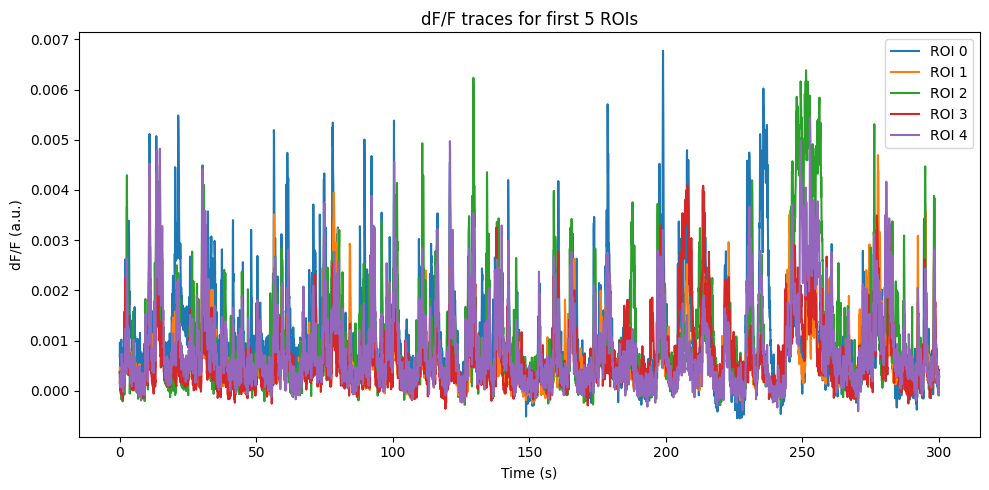

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Access 'dff_chn0' ROI response series
fluorescence = ophys.data_interfaces['Fluorescence']
dff = fluorescence.roi_response_series['dff_chn0']

num_rois = 5
data = dff.data[:, :num_rois]  # shape: (timepoints, n_roi)
rate = dff.rate
num_timepoints = data.shape[0]
time = np.arange(num_timepoints) / rate

plt.figure(figsize=(10,5))
for i in range(num_rois):
    plt.plot(time, data[:, i], label=f'ROI {i}')
plt.xlabel('Time (s)')
plt.ylabel('dF/F (a.u.)')
plt.title('dF/F traces for first 5 ROIs')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Exploring and Visualizing Segmentation Masks

The detected ROIs are defined in the `'PlaneSegmentation_1'` table. Let's:
- Count the number of ROIs.
- Visualize the summed spatial footprints of the first 10 ROI masks.

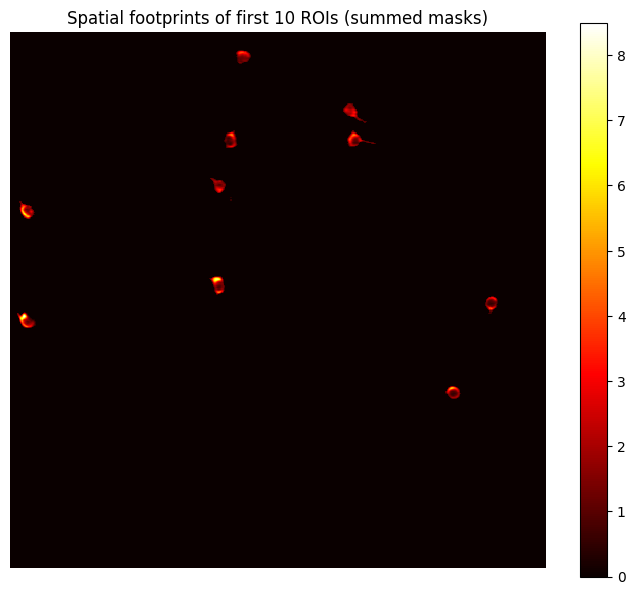

Total number of ROIs in segmentation: 143


In [5]:
# Access the segmentation DataFrame
imgseg = ophys.data_interfaces['ImageSegmentation']
planeseg = imgseg.plane_segmentations['PlaneSegmentation_1']
df = planeseg.to_dataframe()
num_total_rois = len(df)

# Visualize summed footprints of first 10 ROI masks
plt.figure(figsize=(7,6))
canvas = np.zeros((512, 512))  # Assume generic size; adjust if the actual field size is known
n_display = min(10, num_total_rois)
for idx in range(n_display):
    mask = df.iloc[idx]['pixel_mask']
    for (x, y, v) in mask:
        canvas[int(y), int(x)] += v

plt.imshow(canvas, cmap='hot', interpolation='nearest')
plt.title(f'Spatial footprints of first {n_display} ROIs (summed masks)')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Total number of ROIs in segmentation: {num_total_rois}")

## 6. Distribution of ROI Sizes

Finally, let's summarize the size (pixel count) of each detected ROI and plot a histogram to understand the segmentation's properties.

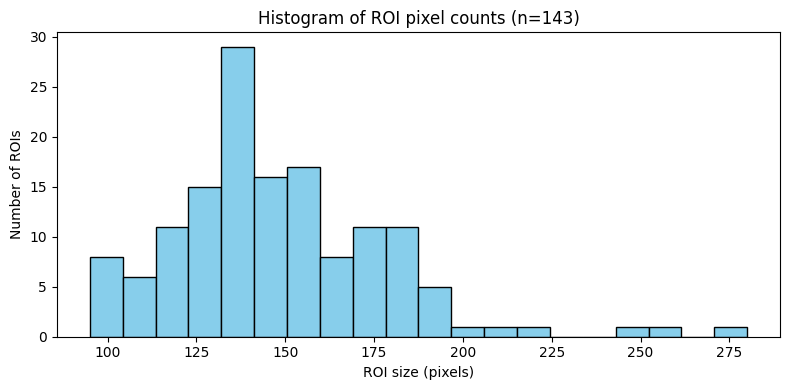

{'num_rois': 143, 'min_roi_size': 95, 'max_roi_size': 280, 'mean_roi_size': 148.41958041958043, 'median_roi_size': 143.0}


In [6]:
# Compute number of pixels in each ROI
roi_sizes = [len(mask) for mask in df['pixel_mask']]

plt.figure(figsize=(8,4))
plt.hist(roi_sizes, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('ROI size (pixels)')
plt.ylabel('Number of ROIs')
plt.title(f'Histogram of ROI pixel counts (n={num_total_rois})')
plt.tight_layout()
plt.show()

# Print summary statistics
print({
    'num_rois': len(roi_sizes),
    'min_roi_size': int(np.min(roi_sizes)),
    'max_roi_size': int(np.max(roi_sizes)),
    'mean_roi_size': float(np.mean(roi_sizes)),
    'median_roi_size': float(np.median(roi_sizes)),
})

---
## Summary and Next Steps

This notebook provided a step-by-step introduction to Dandiset 001349:
- How to enumerate available NWB files
- How to stream and summarize NWB file content
- How to extract and visualize both time series data and segmentation masks
- How to compute useful statistics about segmentation outputs

For more advanced or customized analysis, refer to the [official DANDI documentation](https://www.dandiarchive.org), NWB documentation, and original dataset methods.

*If you wish to analyze a different NWB file or explore other data modalities, you can adapt the code provided here.*

---

**End of Notebook**